<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [17]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import cupy as cp
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin)*cdf + vmin
    
    return v.reshape((nz,nx))

# Define cost function
def cost(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u_sparse = sc.sparse.csc_matrix(u.flatten().reshape(-1,1))
	penalty = u_sparse.T.dot(Q).dot(u_sparse) * alpha
	penalty = float(penalty.toarray())
	# penalty = .5 * u.T.dot(Q.toarray()).dot(u) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	u_sparse = sc.sparse.csc_matrix(u.flatten().reshape(-1,1))

	return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.dot(u_sparse).toarray().flatten() * alpha

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])

# Forward Propagation

In [18]:
# Import saved sample from prior
import pickle
# load data
filename = './data/u_ref'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# save data
# filename = './data/Q'
# outfile = open(filename, 'wb')
# pickle.dump(Q, outfile)
# outfile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# # Propagajtion
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device)
print("shape of p(z,x,t) =", p.shape)

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800
Number of receivers: 156


KeyboardInterrupt: 

# Observe data

In [ ]:
# std_noise = 1 # define the noise level
d_obs_no_noise = p[zxrec[0], zxrec[1], :]
d_obs = d_obs_no_noise
std_noise = 0.01 
# d_obs = d_obs_no_noise + np.random.normal(0, std_noise, d_obs_no_noise.shape)
# print("Observation noise std =", std_noise)

labelsize = 16
plt.figure(figsize=(12,12), dpi=300,facecolor='white')
pmax = np.max(np.abs(p))/10.
for i in range(1,5):
    plt.subplot(2,2,i)
    t = int(i*(nt)) // 6
    plt.title('Snapshot '+str(i)+'   t='+str(t*dt)[:4]+'s',fontsize=labelsize+10)
    plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
    plt.imshow(p[:,:,t], cmap='bwr', vmin=-pmax, \
                vmax=pmax, extent=[ax[0],ax[-1],az[-1],az[0]], \
                aspect='equal')
    plt.xlabel('Distance (m)', fontsize=labelsize)
    plt.ylabel('Depth (m)', fontsize=labelsize)
    plt.xticks(fontsize=labelsize)
    plt.yticks(fontsize=labelsize)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4),dpi=300)
plt.subplot(1,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.8,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{true}$",fontsize=labelsize+4)
plt.subplot(1,2,2)
maxd = np.abs(d_obs).max()
plt.imshow(d_obs.T,cmap='bwr',vmin=-maxd,vmax=maxd,extent=[az[0], az[-1],at[-1], at[0]], aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Amplitude")
# plt.title("$d_{obs}$ with noise $\sigma_{Noise}$=%.2f  " % std_noise, fontsize=labelsize)
plt.title("$d_{obs}$", fontsize=labelsize)
plt.xlabel('Receiver distance (m)', fontsize=labelsize)
plt.ylabel('Time (s)', fontsize=labelsize)
plt.tight_layout()
plt.show()

# Minimization

In [ ]:
# minimize cost function
start = time.time()
u_init = np.zeros([nz, nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = cost, 
               x0 = u_init.flatten(), 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant,
               options = {'disp':True, 'maxiter':5},
               callback=callback
              )
u_fwi = np.reshape(resi.x,(nz,nx))
v_fwi = f(u_fwi)
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

In [ ]:
plt.figure(figsize=(10,8),dpi=100)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(v_fwi,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)
plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

# Variational Bayesian
The objective function evidence lower bound (ELBO) can be written as:

$ELBO(q) = E_q[\log p(d_{obs},v)] - E_q[\log q(v)]$

where $q(v)$ is the variational distribution, $p(d_{obs},v)$ is the joint likelihood of the observed data and model, and $E_q$ denotes the expectation over the variational distribution. The first term encourages the variational distribution to assign high probability to configurations of the model and data that are likely under the true (unknown) posterior distribution, while the second term encourages the variational distribution to be simple and tractable. The objective is to find the variational distribution that maximizes the ELBO.

KL divergence is defined as:

$KL(q(v) || p(v|d_{obs})) = E_q[\log \frac{q(v)}{p(v|d_{obs})}]$

Using Bayes' theorem, we can express the true posterior as:

$p(v|d_{obs}) = \frac{p(d_{obs}|v)p(v)}{p(d_{obs})}$

Substituting this into the definition of the KL divergence gives:

$KL(q(v) || p(v|d_{obs})) = E_q[\log \frac{q(v)}{p(d_{obs}|v)p(v)/p(d_{obs})}]$

$= E_q[\log \frac{q(v)}{p(d_{obs}|v)p(v)}] + \log p(d_{obs})$

The first term on the right-hand side is $-E_q[\log p(v|d_{obs})]$, which is equal to $E_q[\log p(d_{obs},v)] - E_q[\log p(d_{obs})]$. The second term is a constant with respect to $v$, so we can ignore it when optimizing the ELBO with respect to $q(v)$. Thus, minimizing the KL divergence is equivalent to maximizing the ELBO, as we want to get as close as possible to the true posterior.

In [1]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
print('GPU:',tf.config.list_physical_devices('GPU'))
from func.propagation_tf import simulate_obs

def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin)*cdf + vmin
    
    return v.reshape((nz,nx))

def f_tf(u, vmin=2000, vmax=3000):
    cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
    # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
    v = (vmax - vmin) * cdf + vmin
    return v

import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

2023-03-10 15:16:28.098036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 15:16:28.229652: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 15:16:28.793105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-03-10 15:16:28.793333: W tensorflow/comp

GPU: []


2023-03-10 15:16:29.499193: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-10 15:16:29.499221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: himalaya-fon
2023-03-10 15:16:29.499226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: himalaya-fon
2023-03-10 15:16:29.499276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-03-10 15:16:29.499297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-03-10 15:16:29.499302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3


dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 104


2023-03-10 15:16:29.806011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


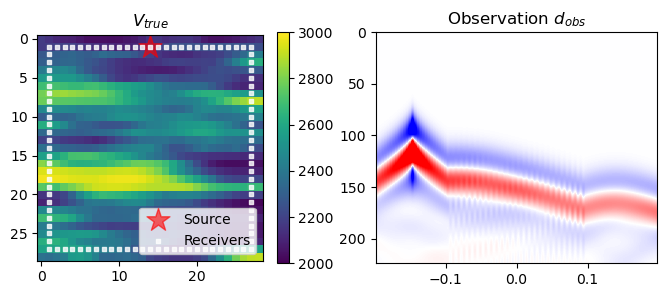

In [2]:
# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
d_obs = simulate_obs(f_tf(u_ref), wsrc, zxsrc, at, az, ax, next, zxrec)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.numpy().T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

In [7]:
# Define the number of iterations for the optimization
num_iters = 100
# Define the number of samples for the variational posterior
num_samples = 10

# Define the prior distribution for the model parameters
std_noise = 0.01
# prior_cov = np.linalg.inv(Q)
prior_mean = tf.zeros([nz, nx], dtype=tf.float32)
prior_cov = 1/Q.diagonal().reshape((nz,nx))
prior_scale = tf.cast(tf.sqrt(prior_cov), dtype=tf.float32)

# Define the likelihood function for the observed data
def log_likelihood_fn(d_obs, u):
    noise_var = std_noise**2  # Assuming Gaussian noise with variance 0.01
    # Calculate J
    d = simulate_obs(f_tf(u), wsrc, zxsrc, at, az, ax, next, zxrec)
    J = .5 * tf.reduce_sum((d - d_obs)**2)
    log_likelihood = - J / noise_var
    # log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / noise_var
    log_likelihood = tf.cast(log_likelihood, tf.float32)
    return log_likelihood

# Define the KL divergence term between the variational posterior and the prior
def kl_divergence_fn(q_dist):
    p_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_mean, scale_diag=prior_scale)
    kl_divergence = tfp.distributions.kl_divergence(q_dist, p_dist)
    return kl_divergence

# Define the TensorFlow probability distributions for the likelihood and prior
d_obs_dist = tfp.distributions.MultivariateNormalDiag(loc=d_obs, scale_diag=tf.ones_like(d_obs)*std_noise)
u_prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_mean, scale_diag=prior_scale)

# Define the TensorFlow variables for the variational posterior mean and scale
q_mean = tf.Variable(tf.random.normal([nz, nx]), dtype=tf.float32)
# Use Transformed Variable to ensure that the variable remains positive during optimization.
q_scale = tfp.util.TransformedVariable(prior_scale, tfp.bijectors.Exp(), trainable=True)
# Initial q
q_mean = tf.Variable(prior_mean)

optimizer = tf.keras.optimizers.Adam()

In [8]:
# Hyper-parameters
reduce_lr_every = 50
optimizer.learning_rate = 0.01
print(f"Initial learning rate {optimizer.learning_rate.numpy()}")
# Train the variational posterior using the ELBO objective
for i in range(num_iters):
    print('Iter',i)
    with tf.GradientTape() as tape:
        tape.watch([q_mean, q_scale.trainable_variables[0]])
        # Sample from the variational posterior
        q_dist = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
        u_samples = q_dist.sample(num_samples)
        # Compute the log(d_obs|v) log-likelihood and log(q) entropy terms for each sample
        likelihoods = [log_likelihood_fn(d_obs, u) for u in u_samples]
        # kl_divergences = [kl_divergence_fn(q_dist) for _ in range(num_samples)]
        log_q = q_dist.log_prob(u_samples)
        # Compute ELBO
        # neg_elbo = - tf.reduce_mean(likelihoods) + tf.reduce_mean(kl_divergences)
        elbo = tf.reduce_mean(likelihoods) - tf.reduce_mean(log_q)
        # Compute objective function
        cost = - elbo
        print('-log(d_obs|v) log(q)-Entropy  Cost') 
        print(-tf.reduce_mean(likelihoods).numpy(),
              tf.reduce_mean(log_q).numpy(),
              cost.numpy())
    # Minimize the negative ELBO with respect to the variational posterior parameters
    grads = tape.gradient(cost, [q_mean, q_scale.trainable_variables[0]])
    optimizer.apply_gradients(zip(grads, [q_mean, q_scale.trainable_variables[0]]))
    
    # Reduce the learning rate if the performance doesn't improve
    if i % reduce_lr_every == 0 and i > 0:
        new_lr = optimizer.learning_rate.numpy() * 0.1
        optimizer.learning_rate = new_lr
        print(f"Reduced learning rate to {new_lr}")
    # Print the ELBO objective every 10 iterations

Initial learning rate 0.009999999776482582
Iter 0
-log(d_obs|v) log(q)-Entropy  Cost
51965000.0 19.424425 51965020.0
Iter 1
-log(d_obs|v) log(q)-Entropy  Cost
49932930.0 19.489653 49932948.0
Iter 2
-log(d_obs|v) log(q)-Entropy  Cost
47910028.0 19.429195 47910050.0
Iter 3
-log(d_obs|v) log(q)-Entropy  Cost
47692412.0 19.162323 47692430.0
Iter 4
-log(d_obs|v) log(q)-Entropy  Cost
46090384.0 19.235641 46090404.0
Iter 5
-log(d_obs|v) log(q)-Entropy  Cost
44754724.0 18.808802 44754744.0
Iter 6
-log(d_obs|v) log(q)-Entropy  Cost
43670508.0 19.176184 43670530.0
Iter 7
-log(d_obs|v) log(q)-Entropy  Cost
41912044.0 19.14331 41912064.0
Iter 8
-log(d_obs|v) log(q)-Entropy  Cost
40005940.0 19.335934 40005960.0
Iter 9
-log(d_obs|v) log(q)-Entropy  Cost
40957556.0 19.063541 40957576.0
Iter 10
-log(d_obs|v) log(q)-Entropy  Cost
38353210.0 19.124117 38353228.0
Iter 11
-log(d_obs|v) log(q)-Entropy  Cost
36661730.0 18.904335 36661748.0
Iter 12
-log(d_obs|v) log(q)-Entropy  Cost
36139550.0 18.756355 3613

In [2]:
q_posterior = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)

plt.figure(figsize=(16,8),dpi=300)
plt.subplot(2,3,1)
plt.imshow(u_prior_dist.mean())
plt.colorbar()
plt.title("Initial Mean", fontsize=16)

plt.subplot(2,3,2)
plt.imshow(u_prior_dist.variance())
plt.colorbar()
plt.title("Initial Variance", fontsize=16)

plt.subplot(2,3,3)
plt.imshow(f_tf(u_ref))
plt.colorbar()
plt.title("Prior sample($v_{True}$)", fontsize=16)

plt.subplot(2,3,4)
plt.imshow(f_tf(q_posterior.mean()))
plt.colorbar()
plt.title("Posterior Mean $\mu_{v}$", fontsize=16)

plt.subplot(2,3,5)
plt.imshow(q_posterior.stddev())
plt.colorbar()
plt.title("Posterior Uncertainties $\sigma_{u}$", fontsize=16)

plt.subplot(2,3,6)
plt.imshow(f_tf(q_posterior.sample()))
plt.colorbar()
plt.title("Posterior sample", fontsize=16)
plt.show()

NameError: name 'tfp' is not defined